# Concrete Crack Classification 

### Imports

In [1]:
%matplotlib inline
import os
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import shutil
from zipfile import ZipFile
from tqdm import tqdm

In [2]:
help(shutil)

Help on module shutil:

NAME
    shutil - Utility functions for copying and archiving files and directory trees.

MODULE REFERENCE
    https://docs.python.org/3.7/library/shutil
    
    The following documentation is automatically generated from the Python
    source files.  It may be incomplete, incorrect or include features that
    are considered implementation detail and may vary between Python
    implementations.  When in doubt, consult the module reference at the
    location listed above.

DESCRIPTION
    XXX The functions here don't copy the resource fork or other metadata on Mac.

CLASSES
    builtins.OSError(builtins.Exception)
        Error
            SameFileError
        ExecError
        SpecialFileError
    
    class Error(builtins.OSError)
     |  Base class for I/O related errors.
     |  
     |  Method resolution order:
     |      Error
     |      builtins.OSError
     |      builtins.Exception
     |      builtins.BaseException
     |      builtins.object
    

In [3]:
os.listdir("Data/")

['data_zip.zip', 'Negative', 'Positive', 'test', 'train']

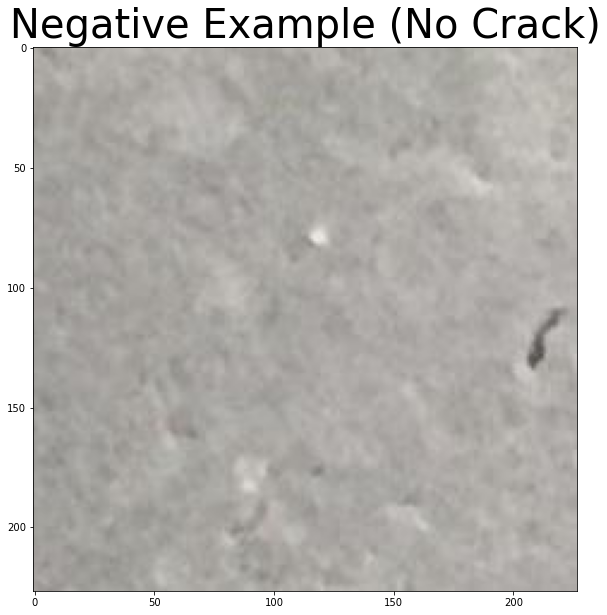

In [7]:
neg_example = plt.imread("Data/Negative/00001.jpg")
pos_example =  plt.imread("Data/Positive/00001.jpg")
plt.figure(figsize = (20, 10))
plt.imshow(neg_example)
plt.title("Negative Example (No Crack)", fontsize = 40)
plt.show()

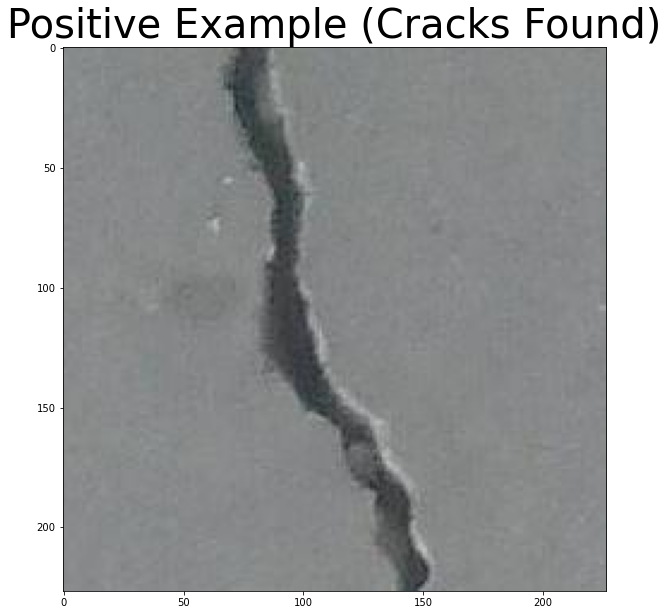

In [8]:
plt.figure(figsize = (20, 10))
plt.imshow(pos_example)
plt.title("Positive Example (Cracks Found)", fontsize = 40)
plt.show()

In [13]:
POSITIVE_PATHS = np.array(os.listdir("Data/Positive"))
NEGATIVE_PATHS = np.array(os.listdir("Data/Negative"))
print("Total Number of Negative Examples:", len(NEGATIVE_PATHS))
print("Total Number of Positive Examples:", len(POSITIVE_PATHS))
print("Total Amount of Images are:", len(NEGATIVE_PATHS) +len(POSITIVE_PATHS))

Total Number of Negative Examples: 20000
Total Number of Positive Examples: 20000
Total Amount of Images are: 40000


In [14]:
np.random.seed(42)
n_idxs = list(np.random.permutation(len(NEGATIVE_PATHS)))
p_idxs = list(np.random.permutation(len(POSITIVE_PATHS)))
P_SHUFFLED_PATHS = np.array(POSITIVE_PATHS)[p_idxs]
N_SHUFFLED_PATHS = np.array(NEGATIVE_PATHS)[n_idxs]

P_XTRAIN_PATHS = P_SHUFFLED_PATHS[:int(len(p_idxs)*0.75)]
N_XTRAIN_PATHS = N_SHUFFLED_PATHS[:int(len(n_idxs)*0.75)]

N_XTEST_PATHS = N_SHUFFLED_PATHS[int(len(n_idxs)*0.75):]
P_XTEST_PATHS = P_SHUFFLED_PATHS[int(len(p_idxs)*0.75):]

if (os.path.exists("Data/train") == False):
    os.mkdir("Data/train")
    os.mkdir("Data/train/Positive")
    os.mkdir("Data/train/Negative")
    
if (os.path.exists("Data/test") == False):
    os.mkdir("Data/test")
    os.mkdir("Data/test/Positive")
    os.mkdir("Data/test/Negative")



In [26]:
### Prepping file hiearchy for Training data 
"""
for i in tqdm(range(len(N_XTRAIN_PATHS))):
    shutil.copy("Data/Negative/"+N_XTRAIN_PATHS[i], "Data/train/Negative")
    shutil.copy("Data/Positive/"+P_XTRAIN_PATHS[i], "Data/train/positive")
"""

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [03:32<00:00, 70.58it/s]


In [28]:
### Prepping file hiearchy for testing data 
"""
for i in tqdm(range(len(N_XTEST_PATHS))):
    shutil.copy("Data/Negative/"+N_XTEST_PATHS[i], "Data/test/Negative")
    shutil.copy("Data/Positive/"+P_XTEST_PATHS[i], "Data/test/Positive")
"""

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:45<00:00, 47.30it/s]


In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainImageGen  = ImageDataGenerator(
    rescale = 1.0/255,
    featurewise_center=True,
    featurewise_std_normalization=True
)

testImageGen  = ImageDataGenerator(
    rescale = 1.0/255,
    featurewise_center=True,
    featurewise_std_normalization=True
)

train_gen  = trainImageGen.flow_from_directory(
    "Data/train",
    target_size = (227,227),
    batch_size = 2,
    class_mode = "binary"
)
test_gen  = testImageGen.flow_from_directory(
    "Data/test",
    target_size = (227,227),
    batch_size = 32,
    class_mode = "binary"


Found 30000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


Text(0.5, 1.0, '1.0')

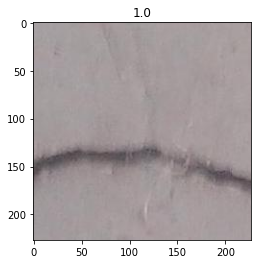

In [20]:
### Testing test_gen to ensure correct image label pairs
t = test_gen.next()
idx = 5
plt.imshow(t[0][idx])
plt.title("{}".format(t[1][idx]))

Text(0.5, 1.0, '1.0')

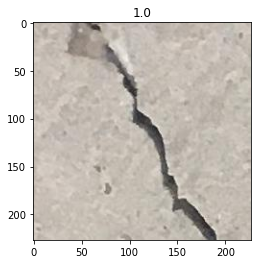

In [31]:
### Testing test_gen to ensure correct image label pairs
t1 = train_gen.next()
idx = 1
plt.imshow(t1[0][idx])
plt.title("{}".format(t1[1][idx]))

In [61]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten#, BatchNormalizaion
from tensorflow.keras import Input, Model
densenet = tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
)
inputs = Input((227, 227,3))
x = densenet(inputs)
x = Flatten()(x)
x = Dense(256)(x)
x = Dense(128)(x)
x = Dense(32)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model = Model(inputs = inputs, outputs = outputs) 

In [62]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 227, 227, 3)]     0         
_________________________________________________________________
densenet201 (Model)          multiple                  18321984  
_________________________________________________________________
flatten_4 (Flatten)          (None, 94080)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               24084736  
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_18 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33  

In [63]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
history = model.fit(train_gen, epochs = 2,  validation_data = test_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15000 steps, validate for 625 steps
Epoch 1/2
    1/15000 [..............................] - ETA: 85:54:25 - loss: 0.2719 - accuracy: 1.0000

c:\users\user\anaconda3\envs\myenv\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\user\anaconda3\envs\myenv\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


15000/15000 [==============================] - 2861s 191ms/step - loss: 1.1712 - accuracy: 0.9571 - val_loss: 0.5914 - val_accuracy: 0.9406
Epoch 2/2
15000/15000 [==============================] - 2877s 192ms/step - loss: 0.1154 - accuracy: 0.9855 - val_loss: 0.2214 - val_accuracy: 0.9649


In [64]:
 model.evaluate(test_gen)

  ...
    to  
  ['...']
625/625 [==============================] - 76s 122ms/step - loss: 0.2214 - accuracy: 0.9649


Text(0.5, 1.0, 'Prediction: [0.05014432] Target: 0.0')

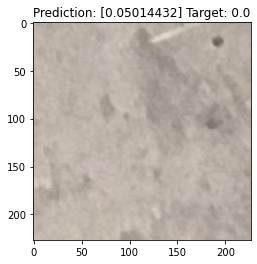

In [66]:
t = test_gen.next()
pred = model.predict(t[0])

i = 0
plt.imshow(t[0][i])
plt.title("Prediction: {} Target: {}".format(pred[i], t[1][i]))

Text(0.5, 1.0, 'Prediction: [0.08585088] Target: 0.0')

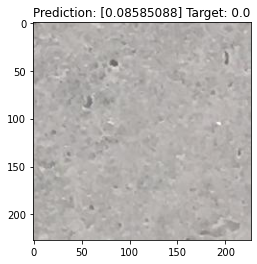

In [67]:
i = 1
plt.imshow(t[0][i])
plt.title("Prediction: {} Target: {}".format(pred[i], t[1][i]))

Text(0.5, 1.0, 'Prediction: [1.] Target: 1.0')

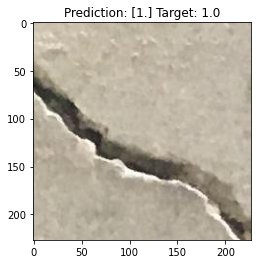

In [68]:
i = 2
plt.imshow(t[0][i])
plt.title("Prediction: {} Target: {}".format(pred[i], t[1][i]))

In [92]:
preds = []
labels = []
for i in tqdm(range(len(test_gen))):
    tmp = test_gen.next()
    tmp_pred = model.predict_on_batch(tmp)
    labels = labels + list(tmp[1])
    preds = preds  + list(tmp_pred.numpy().reshape(1,-1)[0])

100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [01:25<00:00,  7.33it/s]


In [104]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
f1 = f1_score(np.round(preds), labels)
recall = recall_score(np.round(preds), labels)
precision = precision_score(np.round(preds), labels)
accuracy =  accuracy_score(np.round(preds), labels)
print("F1 score: ", f1)
print("Recall Score: ", recall)
print("Precision Score: ", precision)
print("Accuracy: ", accuracy)

F1 score:  0.9657779932137663
Recall Score:  0.9368064698138048
Precision Score:  0.9965986394557823
Accuracy:  0.9647


In [107]:
model_json = model.to_json()
with open("Models/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Models/weights.h5")
print("Saved model to disk")

Saved model to disk


In [105]:
### Saving Models
model.save("Models/crack_classifier.h5")